![caption](active_learning.jpg)

This Notebook demonstrates the process of Active Learning using features from the Stanford movies review database.  It is divided into two short parts: 

1) background about active learning and the purpose of the active learning service  
2) technical demonstration of the iterative Active Learning Service using Scikit-learn  

**Part 1 Background**  

Active Learning is a process that relies on an expert's feedback to help label samples.  The benefit of an Active Learning Service is to learn a model of the concept (in this case sentiment) in a manner that minimizes the need for the expert's time (resources).

The Active Learning Service accomplishes this through an iterative process that trains on the labeled features and then predicts on the unlabeled samples' features.  These predictions can then be evaluated in a manner to suggest the next desirable review for the expert to label.  

For example, ordering based on distance from the classification boundary allows prioritization of the sample that may be questionable.  Once labeled, the iterative process repeats, the labeled features are used to train the model, and predictions are evaluated to provide the next sample(s) for labeling.

In the case of sentiment (as the concept), the positive and negative labels simply a boolean value for each sample.  Here is a positive sentiment sample from the movie review dataset:

**[train/pos/1999_9.txt]**   
*Oliver! the musical is a favorite of mine. The music, the characters, the story. It all just seems perfect. In this rendition of the timeless classic novel turned stage musical, director Carol Reed brings the Broadway hit to life on the movie screen.<br /><br />The transition from musical to movie musical is not an easy one. You have to have the right voices, the right set, the right script, and the right play. All signs point to yes for this play. It almost appears that it was written for the screen!<br /><br />Our story takes place in jolly old England where a boy named Oliver manages to work his way out of the orphanage. He winds his way through the country to London where he meets up with a group of juvenile delinquents, headed by Dodger, the smart talking, quick handed pick-pocket. The leader of this gang is named Fagin, an older fellow who sells all the stolen goods.<br /><br />But all is not well in London town when Bill Sykes played by Oliver Reed and his loving girlfriend Nancy get tangled up with Oliver, Fagin and his young troops, and the law. What ensues is a marvelous tale of love, affection, and great musical numbers.<br /><br />Whether or not you like musicals or not, one listen to these tunes and you will be humming them all day long. Oliver! is a triumph on and off the stage and is a timeless work of art.*

**Part 2 Technical Demonstration**  

In [3]:
# get information about the features, these are precomputed and cached locally
!ls /Users/username/Downloads/features/ | wc -l

  100000


Okay, we have a total of 100,000 movie reviews.

In [10]:
# get information about a review's features
import numpy as np
dat = np.fromfile('/Users/username/Downloads/features/train_pos_1999_9.npy',dtype=np.float32) 
print(len(dat))
print(str(dat))
    

300
[ 0.02389269  0.03208643  0.00130268  0.04201266 -0.03200313 -0.00951154
  0.01946418 -0.02488746  0.01856465  0.04633249 -0.01337551 -0.02968472
 -0.00741054  0.00332867 -0.02204074  0.02735291  0.02232926  0.04266064
 -0.01007411 -0.00491554  0.00753427  0.01638046  0.0167506   0.00097866
  0.01007058 -0.00586906 -0.04155467  0.0172828  -0.01259738  0.01598104
 -0.00583364 -0.00481078 -0.02290771 -0.00967428  0.00477918  0.01339398
  0.00203974 -0.00345512  0.01239723  0.01354235  0.0033645  -0.00636118
  0.00804293  0.00258544  0.01370893 -0.00540722 -0.02329065 -0.0031036
  0.03814979 -0.00680215 -0.02033133  0.01307743  0.01066388 -0.01918704
  0.01334588  0.02784437 -0.00047107 -0.02694349 -0.00936304 -0.02427477
 -0.01462668  0.03339586 -0.01372353 -0.0217119  -0.01895672 -0.00555888
 -0.01645579  0.03707255 -0.00773336  0.02747312  0.0178586  -0.0108341
  0.03610139  0.00416935 -0.04431386 -0.02259126  0.04469617  0.03034797
  0.01368262  0.04607592  0.0065044  -0.05266588 

We see that the 300 features listed above are float values.  These particular features represent the positive movie review for *Oliver!*. 

Lets cover how these 300 features are generated.  Each word in the document is used to find its **word2vec** feature, and then these features are averaged to produce the above document-level feature.  Services like **pymagnitude** are used to create the 300 floats for each word using the query method.  Then, for each document, these are averaged. 

In [ ]:
#!pip install pymagnitude
from pymagnitude import *
import glob

# set up local path
local_path = r'/Users/username/Downloads/aclImdb'
pretrained_magnitude = r'/Users/username/Downloads/GoogleNews-vectors-negative300.magnitude'

vectors = Magnitude(pretrained_magnitude)

def get_cleaned_string(in_string):
    safechars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890 -.'
    cleaned_list = []
    for s in in_string:
        if s in safechars:
            cleaned_list.append(s)
        else:
            cleaned_list.append(' ')
    return ''.join(cleaned_list)

for filename in glob.iglob(local_path+'/**/*.txt', recursive=True):
    with open(filename) as f:
        data = f.read().replace('\n', '')
        cleaned_data = get_cleaned_string(data)
        vecs = vectors.query(cleaned_data.split(' '))r
        avg_vec = np.mean(vecs, axis=(0))
        f_name = filename.replace(local_path + '/','')
        avg_vec.tofile(r'/Users/username/Downloads/features/'+f_name.replace(r'/','_').replace('.txt','.npy'))

With a technical understanding of how the document's feature vector is made, let's move forward to see how the iterative Active Learning Service could be implemented using Scikit-learn.

In [2]:
# lets get a list of each positive and negative labeled features
import glob

pos_list = list()
neg_list = list()
for filename in glob.iglob(r'/Users/username/Downloads/features'+'/*.npy', recursive=False):
    if '_pos_' in filename:
        pos_list.append(filename.replace('/Users/username/Downloads/features/',''))
    if '_neg_' in filename:
        neg_list.append(filename.replace('/Users/username/Downloads/features/',''))

In [3]:
# now, we assume a uniform selection and labeling by randomly picking 500 labeled pos and neg features
pos_list[500]

'train_pos_5318_7.npy'

In [4]:
import random
labeled_pos = random.sample(pos_list, 500)
labeled_neg = random.sample(neg_list, 500)

In [5]:
# lets remove these from the pool of simulated unlabeled values
pos_list = list(set(pos_list) - set(labeled_pos))
neg_list = list(set(neg_list) - set(labeled_neg))

In [17]:
# now generate the training and target data
import numpy as np

np_arr_list = list()
for file in (labeled_pos + labeled_neg):
    dat = np.fromfile('/Users/username/Downloads/features/'+file,dtype=np.float32,count=-1)
    #print(len(dat))
    np_arr_list.append(dat)
    
X_train = np.vstack(np_arr_list)

In [19]:
print(type(X_train))
print(len(X_train))

<class 'numpy.ndarray'>
1000


In [39]:
# now lets build the target, pos = 1 and neg = 0
target = np.concatenate([np.zeros(500),np.ones(500)])
print(target.shape)
print(target)

(1000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [40]:
# lets see some of these labels
print(target[0])
print(target[498])
print(target[499])
print(target[500])
print(target[501])
print(target[999])

0.0
0.0
0.0
1.0
1.0
1.0


In [59]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
model = clf.fit(X_train, target)

In [43]:
# lets predict the output
import numpy as np

np_train_list = list()
for file in (pos_list + neg_list):
    dat = np.fromfile('/Users/username/Downloads/features/'+file,dtype=np.float32,count=-1)
    np_train_list.append(dat)  
X_test = np.vstack(np_train_list)

Let's take a look at how many 'unlabeled' samples do we have.

In [50]:
print(len(pos_list))
print(len(neg_list))
print(len(X_test))

24500
24500
49000


In [68]:
# now predict the 'unknown values'
predictions = model.predict_proba(X_test)

In [69]:
print(type(predictions))

<class 'numpy.ndarray'>


In [70]:
np.unique(predictions)

array([0.33727295, 0.33994489, 0.34103801, ..., 0.65896199, 0.66005511,
       0.66272705])

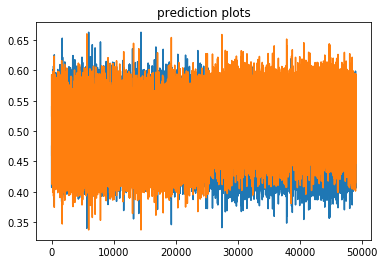

In [71]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.plot(predictions)
plt.title('prediction plots')
plt.show()


Now we evaluate the prediction results and suggest the next label.  The simplest implementation is to get the index of the value closest to the boundary.

In [76]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [77]:
next_to_label_idx = find_nearest(predictions,0.5)

In [78]:
print(next_to_label_idx)

33546


Lets look at this next-to-label file.

In [79]:
(pos_list + neg_list)[next_to_label_idx]

'train_neg_1016_4.npy'

*The movie itself is not too bad; many comments have pointed out the obvious flaws of the script, but it is watchable. What really gives me the creeps though is that people like Justin Timberlake even get cast for movies, and on top of that for movies like this one. I have to admit I had never heard the man's name before watching this, but the very instant he appeared I was just plain annoyed. The voice is crap, the face is a bad rip-off of Legolas, the posture is horrible, and he cannot even properly coordinate all three of them. Said to say, I was delighted when he got jumped after leaving the disco, because I was hoping from then on it would be Morgan Freeman and Kevin Spacey only. Too bad I was wrong. These two and also LL Cool J give a very decent performance, and they are the main reason I give this a 4. <br /><br />I see many upcoming movies with the little Timberlake cast... and cannot believe it.*

So what do you think?  Positive or negative?  Is it apparent why the model may have a harder time classifying this review based on the author's opinion of Justin Timberlake's performance?

The Active Learning process repeats by retraining on a slightly larger labeled set of training data.  The updated model predicts on the somewhat smaller collection of unlabeled data so that the service can return the next best unlabeled review...